# Project 4 Report

This is my report by Project 4 of the Machine Learning Engineer Nanodegree - **Teach a Smartcab How to Drive**. In this project I used reinforcement learning techniques to teach an engine how to play a simple game of reaching a destination on a grid-like world given some restrictions. The project description can be found [here](https://classroom.udacity.com/nanodegrees/nd009/parts/0091345409/modules/540405889375461/lessons/5404058893239847/concepts/54440204820923), and my code for the project is on [this github repo](https://github.com/lmurtinho/machine-learning/tree/my_projects/projects/smartcab).

## Rules of the Game

Our agent should get to its destination on time and respect the following traffic rules:

- If the light is red, the agent generally cannot move - but it can turn right when there is no traffic from the left going forward and no oncoming traffic turning left
- If the light is green, the agent generally can move - but it cannot turn left when there is oncoming traffic going forward or turning right

At each moment in the game, the agent can go forward, turn right, turn left, or do nothing.

## Task 1: Implement a Basic Driving Agent

According to the project's instructions, the basic driving agent should "produce some random move/action." That's easy enough with something like this: 

In [1]:
import random

def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)
    
    # Do something random
    action = random.choice(['right', 'left', 'forward', None])

We'll see below how this strategy fares in avoiding illegal moves and getting the agent to its destination. Spoiler: not very well. 

## Task 2: Identify and Update State

The following information is available for the agent at each update:

- *Light*: whether the light is red or green. As mentioned above, a green light means the agent can perform the next action, with the possible exception of a left turn, while a red light means the agent should stay put, with the possible exception of a right turn. So, it is important to add the light to the state.
- *Oncoming*: whether there is oncoming traffic, and which direction it is going. As mentioned above, oncoming traffic may mean the agent cannot turn left or right, so this information needs to be in the state as well.
- *Right*: whether there is traffic from the right of the agent, and which direction it is going. Right-of-way rules don't mention traffic to the right at any point, so this is unnecessary information that doesn't need to be in the state for the agent to learn the optimal policy.
- *Left*: whether there is traffic from the left of the agent, and which direction it is going. Traffic from the left going forward means the agent cannot turn right on a red light, so this needs to be in the state.
- *Next waypoint*: the direction the agent should go to reach the destination. Without this information, the agent does not know where to go next and might as well wonder around randomly, so this needs to go in the state.
- *Deadline*: how much time the agent has left to reach its destination. At first, I would say this is not meaningful information for the agent, since it doesn't change right-of-way rules nor the best route. I thought about adding it to the state anyway, but this would mean a large increase in the number of possible states. Using only `light` (red or green), `oncoming` (None, left, right, or forward), `left` (None, left, right, or forward) and `next_waypoint` (left, right, or forward), we have $2\times4\times4\times3=96$ possible states. Adding `deadline` would mean multiplying this number by 50, if not more. So I'll keep `deadline` off my state for now.

There is the possibility of combining inputs to create a state. Maybe I could define the state in such a way that the allowed actions would be immediately available for the agent; for instance, I could come up with a `turn_right` variable that would check if the agent can turn right, and add that variable to the state. At least for now, though, I'd rather see how the agent deals with the "raw" variables; I can tweak the state later to try and get the agent to find the optimal policy.

Adding this state implementation to the basic agent presented above leads to the following:

In [3]:
import random

def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)
    
    # update state
    self.state = (inputs['light'], inputs['oncoming'], inputs['left'],
                  self.next_waypoint)
    
    # Do something random
    action = random.choice(['right', 'left', 'forward', None])

## Variables of Interest

Let's go a little deeper on what constitute a good agent in this setting. Some ideas come to mind:

- A good agent would accumulate a large sum of rewards over time
- A good agent would always (or nearly always) reach its destination
- A good agent would learn fast
- A good agent would make no (or very few) mistakes
- A good agent would have a vast knowledge of the state space

Some of these may be redundant in this setting: more rewards, for instance, probably means fewer mistakes, and vice-versa. Still, I think this is a good starting point. So I'll keep track of the following variables:

- `reward_sum`: the sum of rewards for an agent over a simulation
- `disc_reward_sum`: the sum of rewards *discounted over time*, so that an agen that heaps larger rewards faster (i.e. learns faster) will have a larger `disc_reward`
- `n_dest_reached`: the number of times the agent has reached its destination
- `last_dest_fail`: the most recent trial in which the agent did not reach its destination
- `sum_time_left`: the sum over all trials of the steps the agent still had available when it reached its destination (0 if it never reached it)
- `n_penalties`: the number of penalties incurred by the agent
- `last_penalty`: the most recent trial in which the agent received a penalty
- `len_qvals`: how many Q-values are mapped in the agent's Q-function - that is, how many `(state, action)` pairs it visited during the simulation

Putting together the update function, the state to implement and the variables of interest leads to this implementation of a basic agent:

In [8]:
class BasicAgent():
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(BasicAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        self.qvals = {} # mapping (state, action) to q-values
        self.time = 0 # number of moves performed
        self.possible_actions = (None, 'forward', 'left', 'right')
        self.reward_sum = 0 # sum of rewards over all trials in simulation
        self.disc_reward_sum = 0 # discounted sum of rewards
        self.n_dest_reached = 0 # number of destinations reached
        self.last_dest_fail = 0 # last time agent failed to reach destination
        self.sum_time_left = 0 # sum of time left upon reaching destination over all trials
        self.n_penalties = 0 # number of penalties incurred
        self.last_penalty = 0 # last trial in which the agent incurred in a penalty

    def reset(self, destination=None):
        self.planner.route_to(destination)

    def best_action(self, state):
        """
        Return a random action (other agents will have different policies)
        """
        return random.choice(self.possible_actions)

    def update_qvals(self, state, action, reward):
        """
        Does nothing (in other agents will use reward to update 
        the mapping from (state, action) pairs to q-values)
        """
        self.qvals[(state, action)] = 0
    
    def update(self, t):
        # Gather inputs
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        deadline = self.env.get_deadline(self)
        
        # update time and learning rate
        self.time += 1

        # Update state
        self.state = (inputs['light'], inputs['oncoming'], inputs['left'],
                      self.next_waypoint)

        # Pick the best known action
        action = self.best_action(self.state)
        
        # Execute action and get reward
        reward = self.env.act(self, action)
        if reward < 0:
            self.n_penalties += 1
        self.reward_sum += reward
        self.disc_reward_sum += reward / (1 + self.time/100.0)
        
        # Update the q-value of the (state, action) pair
        self.update_qvals(self.state, action, reward)


A file with this version of the agent can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/basic_agent.py). (In the actual code, the implementation is `class BasicAgent(Agent)`.)

All other agents presented in this report will build upon this `BasicAgent` class, changing only the `best_action` and `update_qvals` methods. I altered some code in `simulator.py` to update some `BasicAgents` values, such as `n_dest_reached`.

### Basic Agent Results

Here are the results of running 100 simulations, of 100 trials each, with the basic agent presented above:

In [3]:
import pandas as pd

df_basic = pd.DataFrame.from_csv("basic_agent_results.csv")
df_basic.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000
mean,5.690000,0.700331,19.680000,99.760000,306.560000,1586.110000,99.99,87.310000
std,63.955508,14.582262,4.017336,0.514831,71.353483,55.942773,0.10,6.149148
min,-153.500000,-24.998485,10.000000,98.000000,159.000000,1469.000000,99.00,76.000000
25%,-35.750000,-10.772664,17.000000,100.000000,260.250000,1550.000000,100.00,82.000000
50%,6.250000,0.881820,20.000000,100.000000,296.000000,1587.000000,100.00,87.000000
75%,57.500000,9.462631,22.000000,100.000000,356.250000,1626.000000,100.00,91.250000
max,185.000000,39.070327,30.000000,100.000000,463.000000,1714.000000,100.00,102.000000


As expected, and agent that takes actions at random is a lousy one. I'm actually surprised it gets to its destination some 20 times on average. The number of penalties is quite large - around 16 per trial on average.

Another think to keep in mind: on average, a completely random agent will explore some 87 `(state, action)` pairs in 100 trials. We have $96\times4=384$ such pairs (the 4 possible actions are `'forward'`, `'left'`, `'right'`, and `None`). So randomly picking actions in a state means exploring, on average, about 23% of `(state, action)` pairs. This number seems low, but maybe a lot of states are quite rare and won't come up even after 100 trials.

### Perfect Agent Results

We can contrast the results of the basic agent with those of an agent that always picks the correct action, given by the `best_action` method defined below:

In [4]:
def best_action(self, state):
    """
    Returns the best possible action.
    """        
    # retrieve state information
    light, oncoming, left, waypoint = state

    # retrieve best action        
    action = waypoint

    # On a red light, the agent can only turn right, and even so only if:
    # - no oncoming traffic is going left
    # - no traffic from the left is going forward
    if light == 'red':
        if any([action != 'right', oncoming == 'left', 
                left == 'forward']):
            action = None

    # On a green light, the agent cannot turn left if there is
    # oncoming traffic going forward or right
    elif action == 'left' and (oncoming == 'forward' or oncoming == 'right'):
        action = None

    return action

The perfect agent implementation is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/perfect_agent.py). 

These are the results of the perfect agent:

In [5]:
df_perfect = pd.DataFrame.from_csv("perfect_agent_results.csv")
df_perfect.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.000000
mean,2228.620000,451.682570,99.820000,9.820000,1805.660000,0.0,0.0,22.870000
std,38.217554,18.893056,0.386123,24.621326,67.826013,0.0,0.0,3.083534
min,2154.000000,402.383837,99.000000,0.000000,1575.000000,0.0,0.0,14.000000
25%,2205.000000,437.531399,100.000000,0.000000,1761.750000,0.0,0.0,21.000000
50%,2226.000000,453.240680,100.000000,0.000000,1810.500000,0.0,0.0,23.000000
75%,2254.000000,463.830353,100.000000,0.000000,1846.000000,0.0,0.0,25.000000
max,2350.000000,500.503464,100.000000,99.000000,1988.000000,0.0,0.0,29.000000


Surprisingly, there are occasions in which this perfect agent does not reach its destination. This may be due to issues with the planner or with bad luck (getting a lot of red lights, for instance). On the other hand, the agent incurs in no penalties whatsoever, which is to be expected.

Also note how few `(state, action)` pairs are explored - in fact, something like 1/4 of the explored pairs from the basic agent, which makes sense: for the perfect agent, a state will always be paired with the same (perfect) action, so there are only 96 possibilities for it to explore.

## Task 3: Implement Q-Learning
In this step I return to the basic agent and modify it to learn from its actions.

### Deciding on the Appropriate Q-learning Function 

The general form of the $Q$-function is: 

$Q(s, a) = R(s) + \gamma\underset{s'}\sum T(s,a,s')\underset{a'}{\operatorname{max}}Q(s', a')$

That is, the $Q$-value for a given `(state, action)` pair is the the reward for that state, $R(s)$, plus the discounted expected value of $Q$ for the next state the agent lands in, considering the transition function $T(s,a,s') = \Pr( s' \mid s,a)$ (the probability of landing on state $s'$ coming from state $s$ and performing action $a$) and that, whatever $s'$ is, the agent will maximize $Q$ from there on.

The $Q$-learning update function is given by:

$\hat{Q}_t(s, a) = (1 - \alpha_t)\hat{Q}_{t-1}(s, a) + \alpha_t(r + \gamma\underset{a'}{\operatorname{max}}\hat{Q}_{t-1}(s', a'))$

That is, our estimate of the $Q$-value for the `(state, action)` pair is updated with the learning rate ($\alpha_t$, which varies over time) by the observed reward ($r$) and our previous estimate of the Q-value for the observed next state ($s'$), discounted by the discount factor ($\gamma$) and considering the agent will pick the action $a'$ that maximizes $Q$ from the next state on.

However, in this case there's no need to worry about the future state, since the agent gets an immediate reward for doing the right thing. According to the project description:

>The smartcab gets a reward for each successfully completed trip. A trip is considered “successfully completed” if the passenger is dropped off at the desired destination (some intersection) within a pre-specified time bound (computed with a route plan).

>It also gets a smaller reward for each correct move executed at an intersection. It gets a small penalty for an incorrect move, and a larger penalty for violating traffic rules and/or causing an accident.

So, even though the larger reward is only reaped once the agent reaches its destination, there are smaller rewards for following the correct path, and penalties for not doing so. This should be enough for the agent to learn the best policy.

Granted, ignoring the agent's future decisions means I'm not using some information that could be of help. But the upside is a simplification of the problem: it's as if the agent is playing a 1-round game over and over, with immediate rewards for immediate actions. I expect this simplification more than compensates ignoring long-term rewards in this particular setting.

### Q-learning implementation

This means I won't actually bother with keeping track of the state the agent ends up in after performing an action (or, to be more technical, I'm setting the discount factor $\gamma$ to zero). My update function will then simply be $\hat{Q}_t(s, a) = (1 - \alpha_t)\hat{Q}_{t-1}(s, a) + \alpha_tr$.

Here are the `best_action` and `update_qvals` methods that define such an agent:

In [9]:
def best_action(self, state):
    """
    Returns the best action (the one with the maximum Q-value)
    or one of the best actions, given a state.
    """        
    # get all possible q-values for the state
    all_qvals = {action: self.qvals.get((state, action), 0)
                 for action in self.possible_actions}        

    # pick the actions that yield the largest q-value for the state
    best_actions = [action for action in self.possible_actions 
                    if all_qvals[action] == max(all_qvals.values())]

    # return one of the best actions at random
    return random.choice(best_actions)        

def update_qvals(self, state, action, reward):
    """
    Updates the q-value associated with the (state, action) pair
    """
    # define the learning rate for the current time
    learn_rate = 1.0 / self.time
    
    self.qvals[(self.state, action)] = \
        (1 - learn_rate) * self.qvals.get((self.state, action), 0) + \
        learn_rate * reward

This implementation can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/learning_agent.py)

### Learning Agent Results

Here are the results for this learning agent:

In [10]:
import pandas as pd

df_learning = pd.DataFrame.from_csv("learning_agent_results.csv")
df_learning.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,2221.075000,420.823540,98.970000,15.620000,1743.520000,33.440000,92.580000,52.04000
std,41.377809,23.073574,3.310391,28.086008,99.515948,15.996414,7.487606,6.32283
min,2134.500000,347.789034,67.000000,0.000000,1184.000000,21.000000,71.000000,36.00000
25%,2192.000000,406.123735,99.000000,0.000000,1687.750000,27.750000,88.000000,47.75000
50%,2217.250000,420.593730,99.000000,1.000000,1743.500000,31.000000,96.000000,52.00000
75%,2239.250000,434.152134,100.000000,21.500000,1802.000000,34.000000,98.000000,56.00000
max,2353.500000,476.945379,100.000000,99.000000,1923.000000,166.000000,100.000000,67.00000


These are really good results! The average and median number of destinations reached are actually comparable to the perfect agent's (see above). Let's see how frequent it is to get a late failure at reaching a destination:

In [11]:
print "Number of learning agent simulations with failure to \
reach destination after 90 trials: {}/100".format(sum(df_learning['last_dest_fail'] > 90))

Number of learning agent simulations with failure to reach destination after 90 trials: 5/100


Only 5 times in 100 simulations is there a failure at the last 10 trials. Let's compare this with the perfect agent result:

In [13]:
print "Number of perfect agent simulations with failure to \
reach destination after 90 trials: {}/100".format(sum(df_perfect['last_dest_fail'] > 90))

Number of perfect agent simulations with failure to reach destination after 90 trials: 4/100


Quite close. Also note that when it comes to exploring the state space this is an agent that stays between the perfect agent (that has little time for exploration) and the basic agent (that does nothing but explore at random), with an average of 52 `(state, action)` pairs explored.

If there's room for improvement in this agent, it's in the `last_penalty` variable: in over 75% of the simulations, the agent incurred in at least one penalty in the last 13 trials. On the bright side, 75% of simulations had 34 penalties or fewer - thats 0.34 penalties per trial, or 1 penalty for every 3 trials, which seems quite good specially considering there must be more penalties during the early trials, when the agent knows next to nothing about the world.

## Task 4: Enhance the Driving Agent

The last task, according to the project description, is:

> Apply the reinforcement learning techniques you have learnt, and tweak the parameters (e.g. learning rate, discount factor, action selection method, etc.), to improve the performance of your agent. Your goal is to get it to a point so that within 100 trials, the agent is able to learn a feasible policy - i.e. reach the destination within the allotted time, with net reward remaining positive.

As seen above, this goal has already been reached! But, as also previously discussed, there is still room for improvement, particulary regarding late penalties to the agent.

According to [one of the videos](https://www.udacity.com/course/viewer#!/c-ud728-nd/l-5446820041/m-634899064) in the Reinforcement Learning course, there are three characteristics that can modify a Q-learning algorithm:

- How Q-values are initialized
- How the learning rate decays
- How the action is picked

I'll change each one of these three characteristics at a time, and then I'll tackle everything at once to see it I can get a better learning agent.

### Changing Initial Q-Values

One Q-learning implementation briefly discussed in the Reinforcement Learning lessons for this project is "optimism in the face of uncertainty". The idea is that high initial Q-values (implying an "optimistic" agent in the sense that it initially believes all possible actions will yield excellent rewards) lead to an explorative agent, because it will delay exploiting familiar paths, since those will end up with lower Q-values than its initial estimate.

All it takes for the learning agent above to become optimistic is changing the value it gets when the `(state, action)` pair is not yet a key in `qvals` (that is, when the pair is seen for the first time):

In [15]:
import random

def best_action(self, state):
    """
    Returns the best action (the one with the maximum Q-value)
    or one of the best actions, given a state, being
    optimistic in the face of uncertainty.
    """        
    # get all possible q-values for the state
    # (be optimistic in the face of uncertainty)
    all_qvals = {action: self.qvals.get((state, action), 100)
                 for action in self.possible_actions}        

    # pick the actions that yield the largest q-value for the state
    best_actions = [action for action in self.possible_actions 
                    if all_qvals[action] == max(all_qvals.values())]

    # return one of the best actions at random
    return random.choice(best_actions)        

Instead of getting a 0 for previously unknown `(state, action)` pairs, the agent now gets a breathtaking 100, which is way more than even getting to the destination. So, it has more of an incentive to investigate new paths. (The implementation is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/optimistic_agent.py).)

I thought about also modifying the `update_qvals` method to incorporate the initial optimistic Q-value to the updates, but that's unnecessary, since the point of optimistic initialization is to get the agent to test a given action in a given state. Once it has tested it, there's no need to use that initial optimistic value for anything. (It might be a different story if I were taking future states and actions into account, since then dropping the value of a `(state, action)` pair might mean very shallow observations of many possibilities.)

These are the results for running 100 simulations of 100 trials each with this optimistic agent:

In [16]:
df_optimistic = pd.DataFrame.from_csv("optimistic_agent_results.csv")
df_optimistic.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2226.535000,411.486502,98.750000,28.580000,1743.230000,39.470000,94.090000,63.780000
std,43.024849,18.795427,1.028631,35.816925,84.614498,7.053125,5.818978,6.730873
min,2124.500000,371.443327,95.000000,0.000000,1550.000000,28.000000,74.000000,50.000000
25%,2199.500000,398.500547,98.000000,1.000000,1693.000000,35.000000,92.750000,58.750000
50%,2227.750000,410.429189,99.000000,2.000000,1739.500000,39.000000,96.000000,64.000000
75%,2251.750000,425.188531,99.000000,57.250000,1802.250000,43.000000,99.000000,69.000000
max,2327.000000,466.940263,100.000000,100.000000,2039.000000,81.000000,100.000000,80.000000


In [17]:
print "Number of optimistic agent simulations with failure to \
reach destination after 90 trials: {}/100".format(sum(df_optimistic['last_dest_fail'] > 90))

Number of optimistic agent simulations with failure to reach destination after 90 trials: 12/100


The results of the optimistic agent are somewhat comparable to those of the original learning agent. The main difference is that the number of penalties is somewhat larger, as well as the number of `(state, action)` pairs explored. One thing has to do with another, obviously: exploring more means more chance of getting negative results. When it comes to `last_penalty`, however, optimistic initialization alone does not bring better results than the previous implementation. And the optimistic agent seems more prone to fail to reach a destination even after 90 trials.

### Modifying the Learning Rate Decay

My `learn_rate` variable is the inverse of my `time` variable - that is, when `time` is 1, `learn_rate` is 1/1; when `time` is 2, `learn_rate` is 1/2, and so on.

This drop seems very steep, but it can be modified. I decided to use the following equation to do so:

In [20]:
def learn_rate(mult, time):
    return 1.0 / (1 + mult * time)

That means the learning rate will begin at 1 when `time` is zero, but its decrease will be a function of both `time` and the `mult` factor. If `mult = 1`, the learning rate is the inverse of `time` (assuming `time` starts at zero).

Since I think the drop in the learning rate is steep enough when `mult = 1`, I won't bother with larger values of it, which would only magnify the drop. Instead, I'll work with 10 values of `mult`, from 1 to 0.001.

My prior on this experiment is actually that the learning rate will not have a significant impact on the learner. Because of how the rewards are structured (immediate negative rewards for incorrect or illegal moves, immediate positive rewards for the correct legal move, zero for staying put), and since only one action is correct at any one point, the rewards very quickly should take the following pattern:

- incorrect/illegal moves: minus something
- staying put: zero
- correct legal move: plus something

What `something` is does not really matter: the correct legal move will always win out.

The only way I can think for something to go wrong is if an agent performs an incorrect move that *immediately takes it to the destination*. In this scenario, the positive reward for reaching the destination would overwhelm the negative reward for making an incorrect move, and, if the learning rate drops too quickly, no future penalties would be able to revert this. But, considering the simulation does not allow illegal moves (the agent takes the penalty for trying something illegal, but stays put), how would a legal move that takes the agent to the destination be an incorrect one?

Anyway, the point here is that I think tweaking with the learning rate will not be of much use given the rewards, the behavior of the agent and the states I came up with. Let's see if I'm right.

This is the `update_qvals()` function for the learning agent with different learning rates (`best_action()` stays the same):

In [21]:
def update_qvals(self, state, action, reward):
    """
    Updates the q-value associated with the (state, action) pair
    """
    # define the learning rate for the current time
    learn_rate = 1.0 / (1 + self.mult*self.time)

    self.qvals[(self.state, action)] = \
        (1 - learn_rate) * self.qvals.get((self.state, action), 0) + \
        learn_rate * reward

And this is the way I came up with to run the code using different values for `mult`:

In [24]:
import pandas

def run(mult): # in the code this runs the simulation and passes mult along to the agent
    pass

def go(): # in the actual code this is if __name__ = '__main__':
    mults = [1, 0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.005, 0.003, 0.001]
    for mult in mults:
        idx = mults.index(mult)
        results = []
        for i in range(100):
            sim_results = run(mult)
            results.append(sim_results)
        df_results = pd.DataFrame(results)
        df_results.columns = ['reward_sum', 'disc_reward_sum', 'n_dest_reached',
                              'last_dest_fail', 'sum_time_left', 'n_penalties',
                              'last_penalty', 'len_qvals']
        df_results.to_csv('rate_change_agent_{}_results.csv'.format(idx))

The code for studying changes in learning rates is [here]().

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize'] = 12

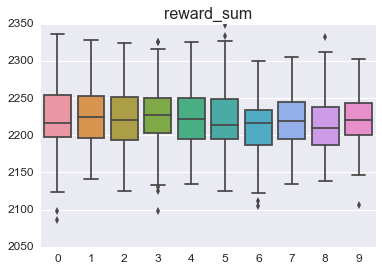

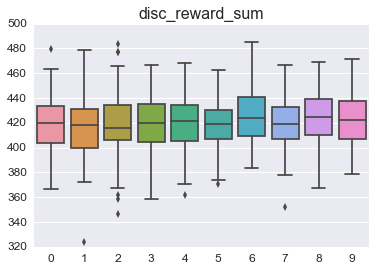

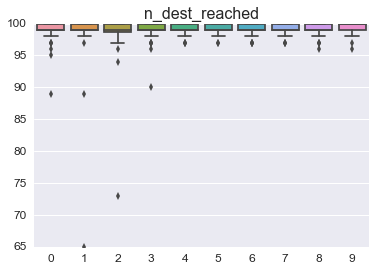

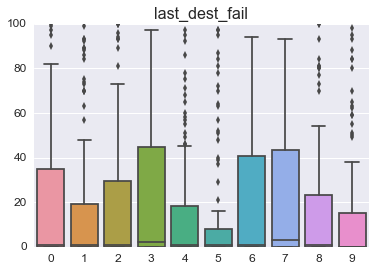

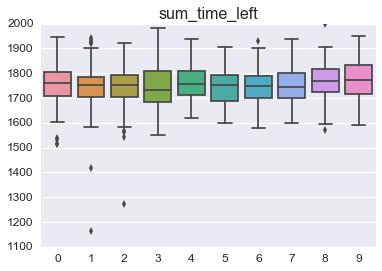

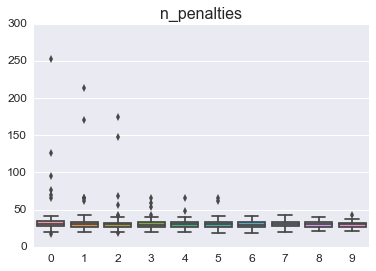

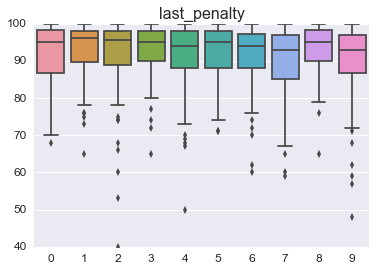

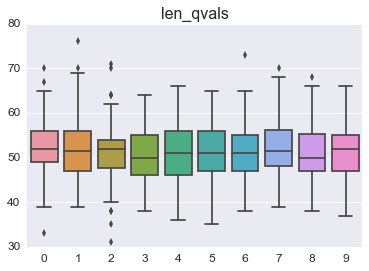

In [39]:
learning_rate_results = {str(i): pd.DataFrame.from_csv('rate_change_agent_{}_results.csv'.format(i))
                         for i in range(10)}

panel = pd.Panel.from_dict(learning_rate_results)
for column in df_learning.columns:
    sns.boxplot(data=panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()

My prior is confirmed: for this agent, tweaking the learning rate doesn't do much. `last_penalty`, in particular, remains on average as high as it was before.

In [10]:
# self.visits is initialized as empty dict
def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)

    # Update state
    self.state = (inputs['light'], inputs['oncoming'], 
                  inputs['left'], self.next_waypoint)

    # update time
    self.time += 1

    # Pick the best known action
    action = self.best_action(self.state)

    # update learning rate according to 
    # number of times (state, action) pair has been seen
    qval_pair = (self.state, action)
    self.visits[qval_pair] = self.visits.get(qval_pair, 0) + 1
    learn_rate = 1.0 / self.visits[qval_pair]

    # Execute action and get reward
    reward = self.env.act(self, action)
    if reward < 0:
        self.n_penalties += 1
    self.reward_sum += reward
    self.disc_reward_sum += reward / (self.time/10.0)

    # Update the q-value of the (state, action) pair
    self.qvals[qval_pair] = \
        (1 - learn_rate) * self.qvals.get(qval_pair, 5) + \
        learn_rate * reward 

And let's see the results for the optimistic agent with this new learning rate decay:

In [10]:
df_optim_new_rate = pd.DataFrame.from_csv("optim_new_rate_agent_results.csv")
df_optim_new_rate.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,2221.740000,67.730042,98.770000,20.900000,1734.210000,38.480000,93.150000,63.11000
std,37.632626,14.364232,0.951925,28.321923,69.997157,5.584032,6.432831,6.58111
min,2133.000000,38.817431,96.000000,0.000000,1546.000000,28.000000,75.000000,49.00000
25%,2192.000000,56.796555,98.000000,1.000000,1692.000000,35.000000,89.750000,58.00000
50%,2225.000000,66.506843,99.000000,2.000000,1735.500000,38.000000,95.000000,62.00000
75%,2249.000000,77.383936,99.000000,42.750000,1786.250000,41.000000,98.000000,67.25000
max,2305.000000,101.955917,100.000000,95.000000,1892.000000,60.000000,100.000000,81.00000


In [11]:
df_explo_agent = pd.DataFrame.from_csv('exploration_agent_results.csv')
df_explo_agent.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2215.195000,67.290012,98.870000,19.780000,1742.430000,38.610000,93.300000,63.660000
std,44.976363,12.370817,0.949801,32.120851,72.383414,3.987088,7.161203,5.752856
min,2118.500000,40.856899,95.000000,0.000000,1606.000000,24.000000,61.000000,46.000000
25%,2181.375000,57.143028,98.000000,0.000000,1696.250000,36.000000,92.000000,59.000000
50%,2211.750000,67.652997,99.000000,1.000000,1743.000000,39.000000,95.000000,64.000000
75%,2256.000000,75.735055,100.000000,27.000000,1783.250000,41.000000,98.000000,68.000000
max,2300.000000,98.729862,100.000000,100.000000,1938.000000,48.000000,100.000000,75.000000


In [12]:
df_optim_explo_agent = pd.DataFrame.from_csv('optim_new_rate_explo_agent_results.csv')
df_optim_explo_agent.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2213.150000,65.798213,98.740000,19.550000,1736.990000,38.860000,94.240000,63.870000
std,39.198697,12.684568,0.860115,27.702013,51.251705,4.729063,5.375064,6.529892
min,2138.500000,41.724241,96.000000,0.000000,1605.000000,27.000000,73.000000,46.000000
25%,2185.000000,56.604998,98.000000,1.000000,1704.750000,36.000000,92.750000,60.000000
50%,2212.750000,63.140779,99.000000,2.000000,1728.000000,38.000000,95.500000,64.000000
75%,2234.625000,75.777104,99.000000,31.250000,1774.250000,42.000000,98.000000,69.000000
max,2337.000000,98.505511,100.000000,99.000000,1856.000000,51.000000,100.000000,77.000000


In [28]:
df_random = pd.DataFrame.from_csv('random_agent_results.csv')
df_random.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00,100.000000
mean,17.895000,-1.570549,20.090000,99.75000,295.950000,1577.600000,99.99,83.090000
std,83.512241,12.964739,3.954527,0.51981,72.057129,71.859431,0.10,6.493345
min,-191.000000,-24.275923,12.000000,98.00000,135.000000,1412.000000,99.00,62.000000
25%,-37.375000,-13.231432,17.750000,100.00000,245.500000,1533.750000,100.00,79.000000
50%,18.500000,-2.570728,20.000000,100.00000,295.500000,1580.500000,100.00,83.000000
75%,64.250000,7.468151,22.000000,100.00000,345.000000,1625.500000,100.00,87.250000
max,201.500000,33.846332,32.000000,100.00000,491.000000,1745.000000,100.00,98.000000


In [30]:
df_new_rate = pd.DataFrame.from_csv('new_rate_results.csv')
df_new_rate.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2219.260000,79.211070,98.970000,21.760000,1758.120000,28.690000,92.120000,49.830000
std,38.174935,20.663156,0.926108,31.676113,80.348141,4.184374,6.667091,5.257136
min,2137.500000,42.643277,97.000000,0.000000,1591.000000,18.000000,74.000000,40.000000
25%,2193.125000,64.392386,98.000000,0.000000,1711.000000,26.000000,87.750000,45.000000
50%,2217.000000,76.907103,99.000000,1.000000,1759.500000,29.000000,94.000000,50.000000
75%,2245.625000,92.423746,100.000000,38.250000,1818.250000,31.000000,98.000000,54.000000
max,2308.500000,162.305931,100.000000,100.000000,1964.000000,41.000000,100.000000,63.000000


In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 18]
%matplotlib inline

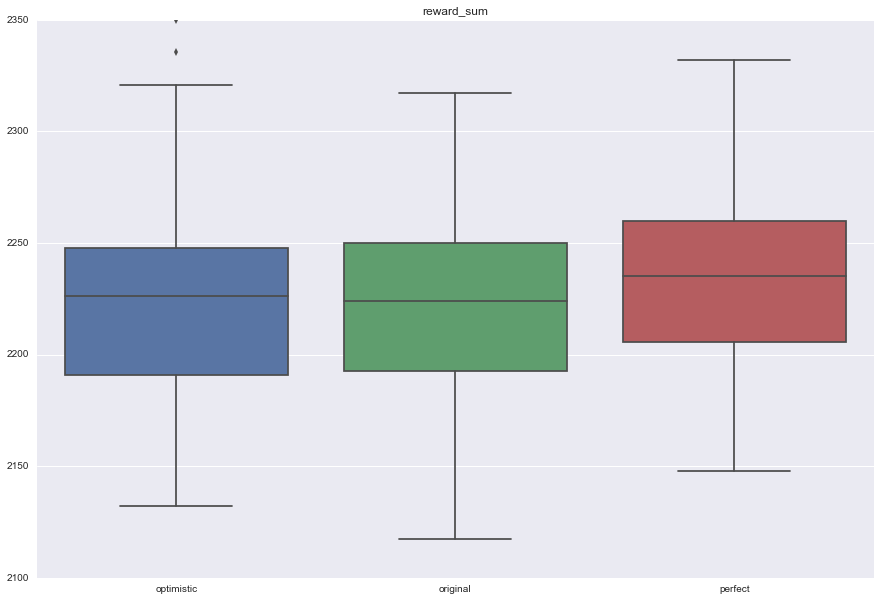

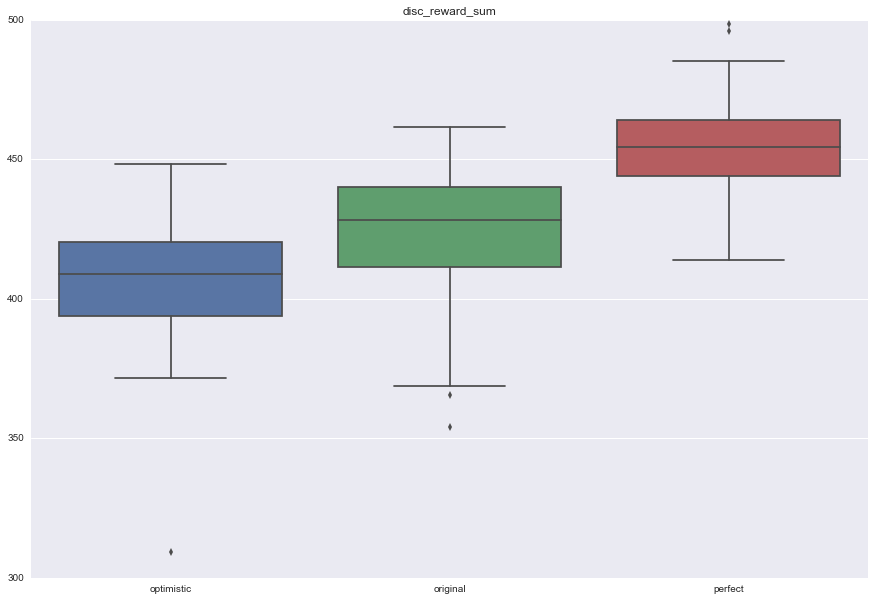

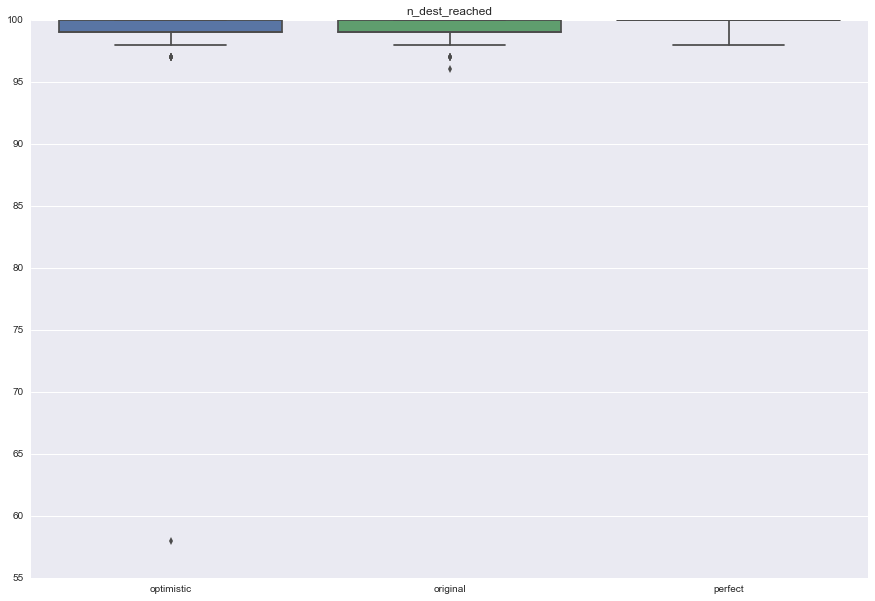

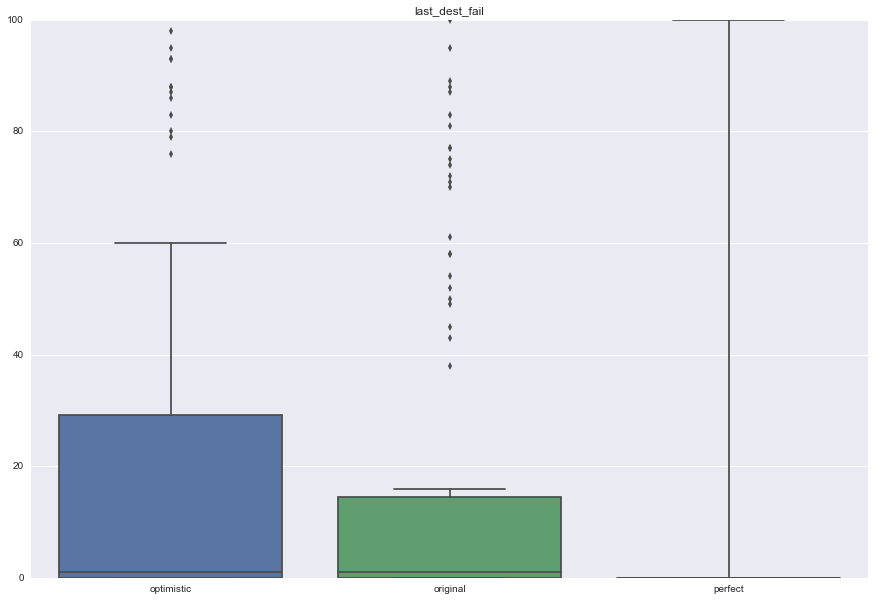

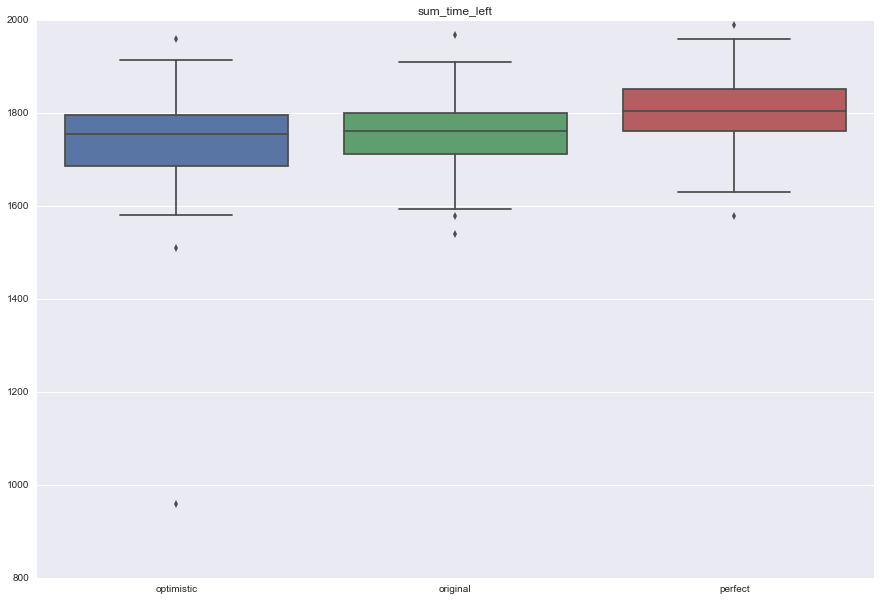

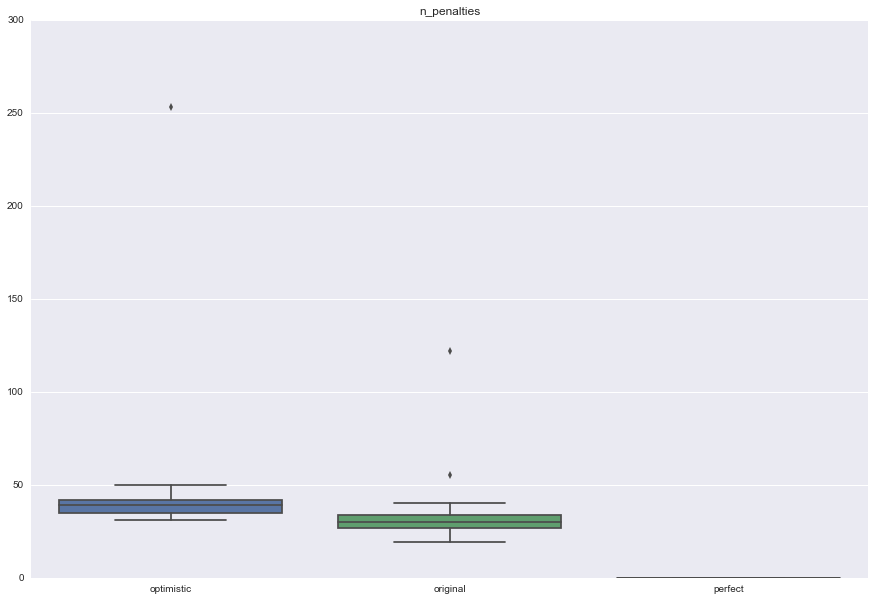

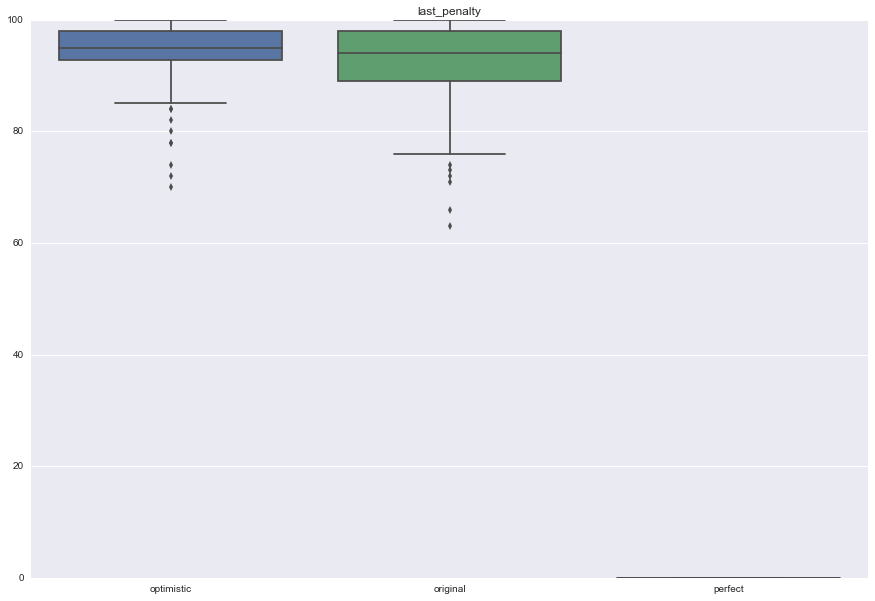

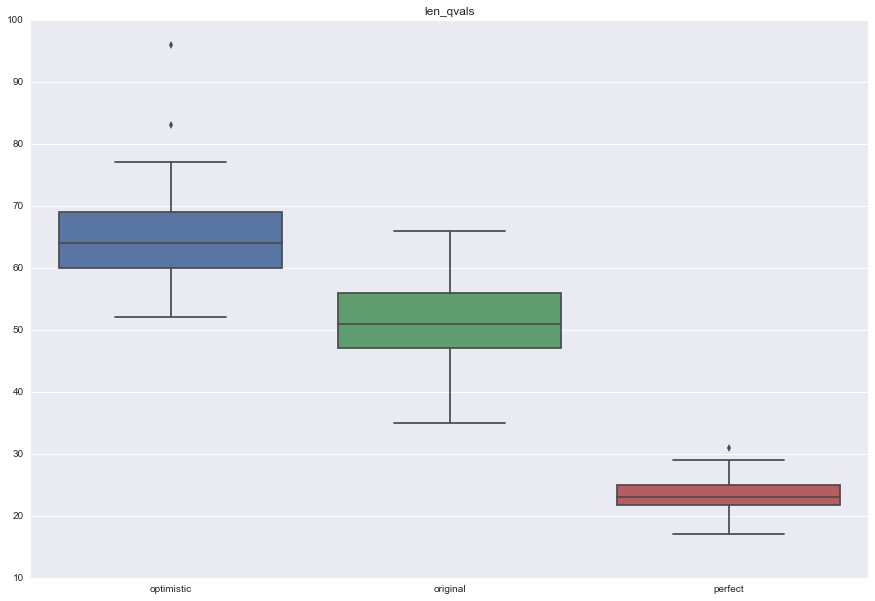

In [34]:
panel = pd.Panel.from_dict({'original': df_learning,
                            'optimistic': df_optimistic,
                            'perfect': df_perfect})
for column in df_learning.columns:
    sns.boxplot(data=panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()

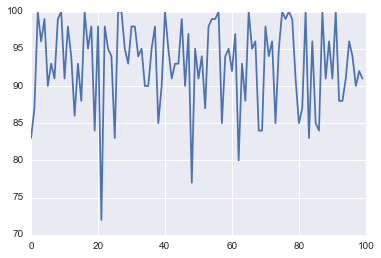

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(df_original['last_penalty'])

#for column in df_original.columns:
#    sns.boxplot(x=column, data=df_original)
#    plt.show()